# US Name
Estimate kandhelwal_quality as a function of  ln_lag_tax_rebate and others variables


# Description

- Change sign for story
- Check sign price adjusted
- Estimate table 1
- Estimate table 2
- Estimate table 4
- Estimate table 5

## Variables
### Target

kandhelwal_quality

### Features

- ln_lag_tax_rebate
- regime
- ln_lag_import_tax

## Complementary information



# Metadata

- Key: 198_VAT_rebate_quality
- Epic: Models
- US: Baseline table
- Task tag: #data-analysis
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name**

- china_vat_quality

**Github**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/04_baseline_vat_quantity_covariates.md



# Connexion server

In [ ]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [ ]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [ ]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [ ]:
change_target <- function(table){
    ## Regime
    check_target <- grep("regimeELIGIBLE:ln_lag_import_tax", rownames(table$coef))
    
    if (length(check_target) !=0) {
    ## SOE
    rownames(table$coefficients)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    rownames(table$beta)[check_target] <- 'ln_lag_import_tax:regimeELIGIBLE'
    } 
    return (table)
}

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [ ]:
db = 'chinese_trade'
table = 'china_vat_quality'

In [ ]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)',
                         'varchar(11)',
                        'array<bigint>',
                        'map<double,boolean>']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [ ]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT 
  * 
FROM 
  chinese_trade.china_vat_quality 
  LEFT JOIN (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          year, 
          hs6, 
          geocode4_corr, 
          country_en, 
          COUNT(
            DISTINCT(regime)
          ) as cn 
        FROM 
          chinese_trade.china_vat_quality 
        GROUP BY 
          year, 
          hs6, 
          geocode4_corr, 
          country_en
      )
  ) as cn on china_vat_quality.year = cn.year 
  and china_vat_quality.hs6 = cn.hs6
  and china_vat_quality.geocode4_corr = cn.geocode4_corr
  and china_vat_quality.country_en = cn.country_en 
  WHERE cn = 2
    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
    except:
        pass
    #s3.download_file(
    #    key = full_path_filename
    #)
    #shutil.move(
    #    filename + '.csv',
    #    os.path.join(path_local, filename + '.csv')
    #)
    #s3.remove_file(full_path_filename)
    

In [ ]:
pd.DataFrame(schema)

In [ ]:
query = """
SELECT * FROM "trade"."wto_wiiw_ntm"
"""
df_ntm = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
          .assign(
        year_initiation = lambda x: x['year_initiation'].astype('Int64'),#.astype(str),
        year_withdrawal = lambda x: x['year_withdrawal'].astype('Int64').astype(str)
    )
          .rename(columns = {"imp_iso3":"iso_alpha", "year_initiation":'year'})
                )
df_ntm.head(2)

In [ ]:
df_ntm.to_csv('ntm.csv')

# Compute NTM and quality variables

## NTM 

### China import and world

In [ ]:
df.shape

In [ ]:
df_ntm.dropna(subset = ['year']).shape

In [ ]:
df_ntm_world = (
    df_ntm.reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["count"].transform(
            "cumsum"
        ),
        lag_count=lambda x: x.groupby(["iso_alpha", "hs6"])["count"]
        .transform("shift")
        .fillna(0),
        lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["lag_count"]
        .transform("cumsum")
        .fillna(0),
        ntm="TRUE",
        lag_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["ntm"]
        .transform("shift")
        .fillna("FALSE"),
    )
    .reset_index()
)

In [ ]:
df_ntm_world

In [ ]:
df_ntm_china = (
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["count"].transform(
            "cumsum"
        ),
        lag_count=lambda x: x.groupby(["iso_alpha", "hs6"])["count"]
        .transform("shift")
        .fillna(0),
        lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["lag_count"]
        .transform("cumsum")
        .fillna(0),
        ntm="TRUE",
        lag_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["ntm"]
        .transform("shift")
        .fillna("FALSE"),
    )
    .reset_index()
    .rename(columns = 
                   {
                       'count':'count_china',
                       'stock_ntm':'stock_ntm_china',
                       'lag_count':'lag_count_china',
                       'lag_stock_ntm':'lag_stock_ntm_china',
                       'ntm':'ntm_china',
                       'lag_ntm':'lag_ntm_china',
                   })
)

In [ ]:
df_ntm_china

- 1) ADP - Antidumping # CHINA
- 2) CVD - Countervailing duties
- 3) EXS - Export subsidies
- 4) QRS - Quantitative Restrictions
- 5) SFG - Safeguards
- 6) SPS - Sanitary and Phytosanitary Measures # CHINA
- 7) SSG - Special Safeguards (agriculture)
- 8) STE - State trading enterprises
- 9) TBT - Technical barriers to trade # CHINA
- 10) TRQ - Tariff-rate quotas

In [ ]:
df_ntm.loc[lambda x: x["iso_alpha"].isin(["CHN"])]['aff'].value_counts()

In [ ]:
#(
#    df_ntm
#    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
#    .loc[lambda x: x['ntm'].isin(['TBT'])]
#)

In [ ]:
list_ntm = []
for i in ['TBT','SPS','ADP']:
    df_temp = (
    df_ntm
    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x['ntm'].isin([i])]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["count"].transform(
            "cumsum"
        ),
        lag_count=lambda x: x.groupby(["iso_alpha", "hs6"])["count"]
        .transform("shift")
        .fillna(0),
        lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["lag_count"]
        .transform("cumsum")
        .fillna(0),
        ntm="TRUE",
        lag_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["ntm"]
        .transform("shift")
        .fillna("FALSE"),
    )
    .reset_index()
    .rename(columns = 
                   {
                       'count':'count_{}'.format(i),
                       'stock_ntm':'stock_ntm_{}'.format(i),
                       'lag_count':'lag_count_{}'.format(i),
                       'lag_stock_ntm':'lag_stock_ntm_{}'.format(i),
                       'ntm':'ntm_{}'.format(i),
                       'lag_ntm':'lag_ntm_{}'.format(i),
                   })
)
    list_ntm.append(df_temp)
len(list_ntm)

In [ ]:
df_ntm.loc[lambda x: x["iso_alpha"].isin(["CHN"])]['aff'].value_counts()

In [ ]:
dvl_econ = [
    'United States',
    'European Union',
    'Japan',
    'South Korea',
    'Canada',
    'Australia',
    'Switzerland',
    'Germany',
    'New Zealand',
    'Netherlands',
    'United Kingdom',
    'Norway',
    'Finland',
    'France',
    'Italy',
    'Belgium',
    'Israel',
    'Sweden',
    'Denmark',
    'Austria'
]

df_country = (
    df_ntm
    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x['aff'].isin(dvl_econ)]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["count"].transform(
            "cumsum"
        ),
        lag_count=lambda x: x.groupby(["iso_alpha", "hs6"])["count"]
        .transform("shift")
        .fillna(0),
        lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["lag_count"]
        .transform("cumsum")
        .fillna(0),
        ntm="TRUE",
        lag_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["ntm"]
        .transform("shift")
        .fillna("FALSE"),
    )
    .reset_index()
    .rename(columns = 
                   {
                       'count':'count_dvp_c',
                       'stock_ntm':'stock_ntm_dvp_c',
                       'lag_count':'lag_count_dvp_c',
                       'lag_stock_ntm':'lag_stock_ntm_dvp_c',
                       'ntm':'ntm_dvp_c',
                       'lag_ntm':'lag_ntm_dvp_c',
                   })
)
df_country.head(1)

In [ ]:
#list_ntm_c[1]

In [ ]:
list_env = [
    "Protection of the environment",
#"Protection of the environment Quality requirements",
#"Protection of the environment Safety",
#"Protection of the environment Trade facilitation"
]

df_ntm_env = (
    df_ntm
    .loc[lambda x: x["iso_alpha"].isin(["CHN"])]
    .loc[lambda x: x['keywords'].isin(list_env)]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .assign(
        stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["count"].transform(
            "cumsum"
        ),
        lag_count=lambda x: x.groupby(["iso_alpha", "hs6"])["count"]
        .transform("shift")
        .fillna(0),
        lag_stock_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["lag_count"]
        .transform("cumsum")
        .fillna(0),
        ntm="TRUE",
        lag_ntm=lambda x: x.groupby(["iso_alpha", "hs6"])["ntm"]
        .transform("shift")
        .fillna("FALSE"),
    )
    .reset_index()
    .rename(columns = 
                   {
                       'count':'count_env',
                       'stock_ntm':'stock_ntm_env',
                       'lag_count':'lag_count_env',
                       'lag_stock_ntm':'lag_stock_ntm_env',
                       'ntm':'ntm_env',
                       'lag_ntm':'lag_ntm_env',
                   })
)
df_ntm_env['lag_ntm_env'].value_counts()

In [ ]:
df.head(2)

Compute frequency, coverage and prevalence ratio:

- D is a dummy variable reflecting the presence of one or more NTMs
- M indicates whether there are imports of good i (also a dummy variable)
- V is the value of imports in product i.
- N is the number of NTMs on product i

To make things simpler, we create different queries

In [ ]:
query = """
SELECT 
    t as year, 
    iso_3digit_alpha_d, 
    COUNT(DISTINCT(hs6)) as M
  FROM 
    "trade"."baci_2002_2020" 
  WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
  GROUP BY 
    t, 
    iso_3digit_alpha_d
"""
df_M = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
        .dropna(subset = ['year', 'iso_3digit_alpha_d'])
       )
            

In [ ]:
query = """
SELECT DISTINCT(hs6), t as year
FROM baci_2002_2020
WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
GROUP BY t, hs6
"""
df_hs_baci = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
)
              .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
       )

In [ ]:
df_hs_baci.groupby(['year'])['hs6'].nunique()

In [ ]:
df_hs_baci.shape

In [ ]:
query = """
SELECT 
    t as year, 
    iso_3digit_alpha_d, 
    hs6,
    SUM(v) as v
  FROM 
    "trade"."baci_2002_2020" 
  WHERE 
    t IN (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010', '2011'
    ) 
  GROUP BY 
    t, 
    iso_3digit_alpha_d,
    hs6
"""
df_hs_baci_v = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
)
              .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
       )

In [ ]:
df_hs_baci_v.head()

In [ ]:
query = """
 WITH test as ( 
 SELECT 
                year_initiation as year, 
                imp_iso3 as iso_3digit_alpha_d, 
                split(hs_combined, '|') as hs_combined 
              FROM 
                wto_wiiw_ntm
            )
           SELECT 
              year, 
              iso_3digit_alpha_d, 
              hs6
            FROM 
              test CROSS 
              JOIN UNNEST(hs_combined) AS t (hs6)           
"""
df_DM = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
          .dropna(subset = ['year', 'iso_3digit_alpha_d','hs6'])
          .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
          #.groupby(['year', 'iso_3digit_alpha_d'])
          #.agg({'hs6':'nunique'})
          #.reset_index()
          #.rename(columns = {'hs6':'DM'})
       )

In [ ]:
query = """
WITH test as ( 
 SELECT 
                id,
                year_initiation as year, 
                imp_iso3 as iso_3digit_alpha_d, 
                split(hs_combined, '|') as hs_combined 
              FROM 
                wto_wiiw_ntm
            )
           SELECT 
              year, 
              iso_3digit_alpha_d, 
              hs6,
              COUNT(id) as NM
            FROM 
              test CROSS 
              JOIN UNNEST(hs_combined) AS t (hs6)  
            GROUP BY 
            year, 
              iso_3digit_alpha_d, 
              hs6
"""
df_DN = (s3.run_query(
            query=query,
            database="trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
          .dropna(subset = ['year', 'iso_3digit_alpha_d','hs6'])
          .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
          #.groupby(['year', 'iso_3digit_alpha_d'])
          #.agg({'hs6':'nunique'})
          #.reset_index()
          #.rename(columns = {'hs6':'DM'})
       )

In [ ]:
df_DN

In [ ]:
df_freq = (
    df_M.merge(
        (
            df_DM.loc[
                lambda x: x["year"].isin(
                    [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
                )
            ]
            .merge(df_hs_baci)
            .groupby(["year", "iso_3digit_alpha_d"])
            .agg({"hs6": "nunique"})
            .rename(columns={"hs6": "DM"})
            .reset_index()
        ),
        how="left",
    ).fillna(0)
    .assign(
    frequency = lambda x: x['DM'] / x['M']
    )
    .set_index(['year', 'iso_3digit_alpha_d'])
    .assign(
    frequency = lambda x: x['frequency'].clip(upper=1)
    )
    .reset_index()
    .rename(columns={"iso_3digit_alpha_d": "iso_alpha"})
    .sort_values(by=["iso_alpha", "year"])
            .assign(
                lag_frequency=lambda x: x.groupby(["iso_alpha"])["frequency"].transform(
                    "shift"
                ),
            )
)

In [ ]:
df_prev = (
    df_M.merge(
        (
            df_DN.loc[
                lambda x: x["year"].isin(
                    [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
                )
            ]
            .merge(df_hs_baci)
            .groupby(["year", "iso_3digit_alpha_d"])
            .agg({"NM": "sum"})
            #.rename(columns={"hs6": "DN"})
            .reset_index()
        ),
        how="left",
    ).fillna(0)
    .assign(
    prevalence = lambda x: x['NM'] / x['M']
    )
    .rename(columns={"iso_3digit_alpha_d": "iso_alpha"})
    .sort_values(by=["iso_alpha", "year"])
            .assign(
                lag_prevalence=lambda x: x.groupby(["iso_alpha"])["prevalence"].transform(
                    "shift"
                ),
            )
)

In [ ]:
df_hs_baci_v.shape

In [ ]:
df_cov = (
    df_hs_baci_v.merge(
        (
            df_DM.loc[
                lambda x: x["year"].isin(
                    [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
                )
            ]
            .merge(df_hs_baci)
            .drop_duplicates()
        ),
        how="left", indicator = True
    )
    .loc[lambda x: x['_merge'].isin(['left_only','both'])]
    .groupby(["year","iso_3digit_alpha_d",'_merge'])
    .agg({'v':'sum'})
    .fillna(0)
    .unstack(-1)
    .collapse_levels(sep='_')
    .assign(coverage = lambda x: x['v_both']/ (x['v_left_only'] + x['v_both']))
    .drop(columns = ['v_right_only'])
    .reset_index()
    .rename(columns={"iso_3digit_alpha_d": "iso_alpha"})
    .sort_values(by=["iso_alpha", "year"])
            .assign(
                lag_coverage=lambda x: x.groupby(["iso_alpha"])["coverage"].transform(
                    "shift"
                ),
            )
)

In [ ]:
df.dtypes

### NTM Chinese city

In [ ]:
query = """
SELECT 
year,
geocode4_corr,
--regime,
hs6,
SUM(value) as V
FROM (
SELECT 
    date as year, 
    geocode4_corr,
    origin_and_destination, 
    CASE WHEN trade_type = '进料加工贸易' 
    OR trade_type = '一般贸易' THEN 'ELIGIBLE' ELSE 'NOT_ELIGIBLE' END as regime, 
    hs as hs6,
    value
  FROM 
    "chinese_trade"."china_import_export" 
INNER JOIN (
        SELECT 
          DISTINCT(citycn) as citycn, 
          geocode4_corr 
        FROM 
          chinese_lookup.china_city_code_normalised
      ) AS city_cn_en ON city_cn_en.citycn = china_import_export.city_prod    
  WHERE 
    date in (
      '2002', '2003', '2004', '2005', '2006', 
      '2007', '2008', '2009', '2010'
    ) 
    AND imp_exp = '进口' 
    AND (
      trade_type = '进料加工贸易' 
      OR trade_type = '一般贸易' 
      OR trade_type = '来料加工装配贸易' 
      OR trade_type = '加工贸易'
    ) 
    AND intermediate = 'No' 
    AND (
      business_type = '国有企业' 
      OR business_type = '私营企业' 
      OR business_type = '集体企业' 
      OR business_type = '国有' 
      OR business_type = '私营' 
      OR business_type = '集体'
    ) 
    AND quantity > 0 
    AND value > 0
      )
      GROUP BY year,
geocode4_corr,
--regime,
hs6
"""
df_VC = (s3.run_query(
            query=query,
            database="chinese_trade",
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
    .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
        )

- count_ntm_china:  Number of new policy per year
- stock_ntm_china:  Number of active policy 
- new_ntm_china: Equal to 1 if a new policy is added
- active_ntm_china: Equal to 1 if the policy is active

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
def compute_score(source, candidate_labels):
    return classifier(source, candidate_labels, multi_label=True)

In [ ]:
(
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    ['ntm'].value_counts()
)

In [ ]:
(
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .loc[lambda x: x['ntm'].isin([
        #'TBT',
        #'SPS',
        'ADP'
    ])]
    #['keywords'].value_counts()
    #.reset_index()
    #.to_excel('test.xlsx')
)

In [ ]:
(
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .loc[lambda x: x['ntm'].isin([
        'TBT',
        'SPS',
        #'ADP'
    ])]
    ['keywords'].value_counts()
    .reset_index()
)

In [ ]:
from tqdm.notebook import tqdm
import json
keywords = (
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .loc[lambda x: x['ntm'].isin([
        'TBT',
        'SPS',
        #'ADP'
    ])]
    ['keywords'].value_counts()
    .reset_index()
)
list_keywords = []
for i in tqdm(range(0,keywords.shape[0])):
    score = compute_score(keywords.loc[i]['index'], ['animal','food', 'safety'])
    list_keywords.append(score)
    with open('TEMP/sentence_{}.json'.format(i), 'w') as outfile:
        json.dump(score, outfile)

In [ ]:
to_exclude = list(
    pd.DataFrame(list_keywords)
    .assign(
    max_proba = lambda x: x['scores'].apply(max),
        to_remove = lambda x: x['max_proba'] >.5
    )
    .loc[lambda x: x['to_remove'].isin([True])]
    ['sequence'].unique()
)
len(to_exclude)

In [ ]:
df_ntm_c = (
    df_ntm
    .loc[lambda x: x['iso_alpha'].isin(['CHN'])]
    .loc[lambda x: x['ntm'].isin([
        #'TBT',
        #'SPS',
        'ADP'
    ])]
    #.loc[lambda x: ~x['keywords'].isin(to_exclude)]
    .reindex(columns=["iso_alpha", "id", "year", "hs_combined"])
    .dropna(subset = ['year'])
    .assign(hs6=lambda x: x["hs_combined"].str.split("|"))
    .explode("hs6")
    .groupby(["iso_alpha", "year", "hs6"])
    .agg({"id": "nunique"})
    .rename(columns={"id": "count"})
    .sort_values(by=["iso_alpha", "year", "hs6"])
    .reset_index()
    
    .pivot_table(
        values="count",
        index=["hs6"],
        columns="year",
        aggfunc="sum",
        fill_value=0,
    )
    .stack()
    .reset_index()
    .rename(columns={0: "count_ntm_china"})
    .assign(
        stock_ntm_china=lambda x: x.groupby(["hs6"])[
            "count_ntm_china"
        ].transform("cumsum"),
        new_ntm_china=lambda x: np.where(x["count_ntm_china"] > 0, 1, 0),
        active_ntm_china=lambda x: np.where(x["stock_ntm_china"] > 0, 1, 0),
    )
    #.loc[lambda x: x['hs6'].isin(['400270'])]

)
df_ntm_c[["count_ntm_china",'stock_ntm_china','new_ntm_china','active_ntm_china']].describe()

In [ ]:
df_ntm_c.loc[lambda x: x['hs6'].isin(['400270'])]

Frequency

In [ ]:
# 656185
df_VC_NTM_C = (
    df_VC
    .merge(df_ntm_c, how = 'left', indicator = True)
)
df_VC_NTM_C['_merge'].value_counts()

In [ ]:
df_VC_NTM_C.head()

In [ ]:
df_freq_c = (
    df_VC_NTM_C.set_index([
        "year",
        "geocode4_corr",
        "hs6",
        "_merge",
        #"regime"
    ])
    .fillna(0)
    .groupby([
        "year",
        "geocode4_corr",
        #"regime"
    ])
    .agg({"active_ntm_china": "sum"})
    .rename(columns = {'active_ntm_china':'DM_C'})
    .merge(
        (df_VC_NTM_C.groupby(["year", "geocode4_corr"]).agg({"hs6": "nunique"}).rename(columns = {'hs6':'M_C'})),
        left_index=True,
        right_index=True,
        how="right",
    )
    .assign(
    F_C = lambda x: x['DM_C']/x['M_C'],
    )
    .reset_index()
    .sort_values(by = [
        'geocode4_corr',
        'year',
        #"regime"
    ])
    .assign(
        lag_DM_C=lambda x: x.groupby(["geocode4_corr", 
                                      #"regime"
                                     ])["DM_C"].transform(
           "shift"
        ),
    lag_F_C=lambda x: x.groupby(["geocode4_corr", 
                                      #"regime"
                                     ])["F_C"].transform(
           "shift"
        )
    )
)
#df_freq_c.head(6)
df_freq_c[["DM_C","M_C","F_C",'lag_DM_C',"lag_F_C"]].describe(percentiles = np.arange(0,1, .05))


coverage

In [ ]:
df_cov_c = (
    df_VC_NTM_C.set_index([
        "year",
        "geocode4_corr",
        "hs6",
        "_merge",
        #"regime"
    ])
    .fillna(0)
    .loc[lambda x: x['active_ntm_china'] > 0]
    .groupby([
        "year",
        "geocode4_corr",
        #"regime"
    ])
    .agg({"V": "sum"})
    .rename(columns = {'V':'DV_C'})
    .merge(
    (df_VC_NTM_C.groupby(["year", "geocode4_corr"]).agg({"V": "sum"}).rename(columns = {'V':'V_C'})),
    left_index= True,right_index = True, how = 'right')
    .assign(
    DV_C = lambda x: x['DV_C'].fillna(0),    
    C_C = lambda x: x['DV_C']/x['V_C'],
    )
    .reset_index()
    .sort_values(by = [
        'geocode4_corr',
        'year',
        #"regime"
    ])
    .assign(
        lag_DV_C=lambda x: x.groupby(["geocode4_corr", 
                                     #"regime"
                                     ])["DV_C"].transform(
            "shift"
        ),
    lag_C_C=lambda x: x.groupby(["geocode4_corr", 
                                      #"regime"
                                     ])["C_C"].transform(
            "shift"
        )
    )
)
df_cov_c[["DV_C","V_C","C_C","lag_DV_C","lag_C_C"]].describe(percentiles = np.arange(0,1, .05))

In [ ]:
df_prev_c = (
    df_VC_NTM_C.set_index([
        "year",
        "geocode4_corr",
        "hs6",
        "_merge",
    #"regime"
    ])
    .fillna(0)
    .groupby([
        "year",
        "geocode4_corr",
        #"regime"
    ])
    .agg({"stock_ntm_china": "sum"})
    .rename(columns = {'stock_ntm_china':'NM_C'})
    .merge(
        (df_VC_NTM_C.groupby(["year", "geocode4_corr"]).agg({"hs6": "nunique"}).rename(columns = {'hs6':'M_C'})),
        left_index=True,
        right_index=True,
        how="right",
    )
    .assign(
    P_C = lambda x: x['NM_C']/x['M_C'],
    )
    .reset_index()
    .sort_values(by = [
        'geocode4_corr',
        'year',
        #"regime"
    ])
    .assign(
    lag_P_C=lambda x: x.groupby(["geocode4_corr", 
                                      #"regime"
                                     ])["P_C"].transform(
            "shift"
        )
    )
)
df_prev_c[["NM_C","M_C","P_C","lag_P_C"]].describe(percentiles = np.arange(0,1, .05))

In [ ]:
df_prev_c.loc[lambda x: x['geocode4_corr'].isin(['1307'])]

### Merge all NTM

In [ ]:
#df_ntm_country.loc[lambda x: x["iso_3digit_alpha_d"].isin(["CHN"])].groupby(['year','iso_3digit_alpha_d'])['frequency'].describe()

In [ ]:
df_final = (
    df.drop(columns=["year.1", "hs6.1", "geocode4_corr.1", "country_en.1"])
    .assign(hs6=lambda x: x["hs6"].astype(str).str.zfill(6))
    .merge(df_ntm_world, on=["iso_alpha", "year", "hs6"], how="left")
    .merge(df_ntm_china.drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(df_ntm_env.drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[0].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[1].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(list_ntm[2].drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(df_country.drop(columns=["iso_alpha"]), on=["year", "hs6"], how="left")
    .merge(
        df_freq,
        on=["year", "iso_alpha"],
        how="left",
    )
    .merge(
        df_prev.drop(columns = ['M']),
        on=["year", "iso_alpha"],
        how="left",
    )
    .merge(
        df_cov,
        on=["year", "iso_alpha"],
        how="left",
    )
    .merge(
        df_freq_c.reindex(columns = [
            "geocode4_corr",
            "year",
            #'regime',
            "DM_C",
            "F_C",
            "lag_DM_C",
            "lag_F_C"
                                    ]),
        on=["year", "geocode4_corr",
            #'regime'
           ],
        how="left",
    )
    .merge(
        df_cov_c.reindex(columns = [
            "geocode4_corr",
            "year",
            #'regime',
            "DV_C",
            "V_C",
            "C_C",
            "lag_DV_C",
            "lag_C_C"
                                   ]),
        on=["year", "geocode4_corr",
            #'regime'
           ],
        how="left",
    )
    .merge(
        df_prev_c.reindex(columns = [
            "geocode4_corr",
            "year",
            #'regime',
            "NM_C",
            "P_C",
            "lag_P_C"
        ]),
        on=["year", "geocode4_corr",
            #'regime'
           ],
        how="left",
    )
    .assign(
        frequency=lambda x: x["frequency"].fillna(0),
        lag_frequency=lambda x: x["lag_frequency"].fillna(0),
        coverage=lambda x: x["coverage"].fillna(0),
        lag_coverage=lambda x: x["lag_coverage"].fillna(0),
        prevalence=lambda x: x["prevalence"].fillna(0),
        lag_prevalence=lambda x: x["lag_prevalence"].fillna(0),
    )
)
df_final = df_final.assign(
    **{
        "{}".format(i): df_final[i].fillna(0)
        for i in [
            "count",
            "stock_ntm",
            "lag_count",
            "lag_stock_ntm",
            "count_china",
            "stock_ntm_china",
            "lag_count_china",
            "lag_stock_ntm_china",
            "count_env",
            "stock_ntm_env",
            "lag_count_env",
            "lag_stock_ntm_env",
            "count_TBT",
            "stock_ntm_TBT",
            "lag_count_TBT",
            "lag_stock_ntm_TBT",
            "count_SPS",
            "stock_ntm_SPS",
            "lag_count_SPS",
            "lag_stock_ntm_SPS",
            "count_ADP",
            "stock_ntm_ADP",
            "lag_count_ADP",
            "lag_stock_ntm_ADP",
            "count_dvp_c",
            "stock_ntm_dvp_c",
            "lag_count_dvp_c",
            "lag_stock_ntm_dvp_c",
            "DM_C",
            "F_C",
            "lag_DM_C",
            "lag_F_C",
            "DV_C",
            "V_C",
            "C_C",
            "lag_DV_C",
            "lag_C_C",
            "NM_C",
            "P_C",
            "lag_P_C"
        ]
    },
    **{
        "{}".format(i): df_final[i].fillna("FALSE")
        for i in [
            "ntm",
            "lag_ntm",
            "ntm_china",
            "lag_ntm_china",
            "ntm_env",
            "lag_ntm_env",
            "ntm_TBT",
            "lag_ntm_TBT",
            "ntm_SPS",
            "lag_ntm_SPS",
            "ntm_ADP",
            "lag_ntm_ADP",
            "ntm_dvp_c",
            "lag_ntm_dvp_c",
        ]
    },
)
df_final.head(1)

## Quality variable: different sigma

- Use different values of sigma:
    -  Set sigma to the elasticity as 5 and 10
        - [Credit Constraints, Quality, and Export Prices: Theory and Evidence from China](https://drive.google.com/file/d/1FnIIq2kwWdcIgg6jm-ydIvzj9f-UApYR/view?usp=sharing)
        - [Credit constraints, quality, and export prices: Theory and evidence from China](https://drive.google.com/file/d/1FnIIq2kwWdcIgg6jm-ydIvzj9f-UApYR/view?usp=sharing)
        
-> code from [01_preparation_quality](https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/01_preparation_quality.md#steps)

In [ ]:
query = """
SELECT geocode4_corr,country_en,year,regime,hs6,iso_alpha,unit_price,quantity
FROM chinese_trade.china_export_tariff_tax
""".format(db, table)
df_vat = (
    s3.run_query(
    query=query,
    database="chinese_trade",
    s3_output="SQL_OUTPUT_ATHENA",
    filename="trade_vat",  # Add filename to print dataframe
    destination_key=None,  # Add destination key if need to copy output
)
    .assign(
              year = lambda x: x['year'].astype('Int64'),
              hs6 = lambda x: x['hs6'].astype('Int64').astype(str).str.zfill(6),
          )
)
df_quality = (
    df_vat.assign(
    hs2 = lambda x: x['hs6'].str[:2],
    hs3 = lambda x: x['hs6'].str[:3],
    hs4 = lambda x: x['hs6'].str[:4],
    sigma_3 = 3,
    sigma_5 = 5,
    sigma_10 = 10

)
    .assign(
        sigma_price3 = lambda x: x['sigma_3'].astype('float') * np.log(x['unit_price']),
        sigma_price5 = lambda x: x['sigma_5'].astype('float') * np.log(x['unit_price']),
        sigma_price10 = lambda x: x['sigma_10'].astype('float') * np.log(x['unit_price']),
        y3 = lambda x : np.log(x['quantity']) + x['sigma_price3'],
        y5 = lambda x : np.log(x['quantity']) + x['sigma_price5'],
        y10 = lambda x : np.log(x['quantity']) + x['sigma_price10']
    )
)
df_quality["FE_ct"] = pd.factorize(df_quality["year"].astype('string') + 
                                       df_quality["country_en"])[0]
compute_quality = False
if compute_quality:
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer
    
    cat_proc = make_pipeline(
        OneHotEncoder()
    )
    preprocessor = make_column_transformer(
        (cat_proc, tuple(['hs6', 'FE_ct']))
    )
    clf = make_pipeline(preprocessor,
                        LinearRegression(fit_intercept=True, normalize=False))
    #%%time
    print('begin model 3')
    MODEL3 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y3']) 
    print('begin model 5')
    MODEL5 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y5']) 
    print('begin model 10')
    MODEL10 = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y10']) 
    from joblib import dump, load
    dump(MODEL3, 'filename3.joblib') 
    dump(MODEL5, 'filename5.joblib') 
    dump(MODEL10, 'filename10.joblib') 

In [ ]:
from joblib import dump, load
df_quality = df_quality.assign(
    prediction3 = lambda x: load('filename3.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual3 = lambda x: x['y3'] - x['prediction3'],
    kandhelwal_quality3 = lambda x: x['residual3'] / (x['sigma_3'].astype('float') -1),
    
    prediction5 = lambda x: load('filename5.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual5 = lambda x: x['y5'] - x['prediction5'],
    kandhelwal_quality5 = lambda x: x['residual5'] / (x['sigma_5'].astype('float') -1),
    
    prediction10 = lambda x: load('filename10.joblib') .predict(x[['hs6', 'FE_ct']]),
    residual10 = lambda x: x['y10'] - x['prediction10'],
    kandhelwal_quality10 = lambda x: x['residual10'] / (x['sigma_10'].astype('float') -1),
)  

In [ ]:
df_final = (
    df_final
    .merge(
    df_quality.reindex(
    columns = ['geocode4_corr','year','regime','hs6','iso_alpha',
              'kandhelwal_quality3','kandhelwal_quality5','kandhelwal_quality10']
    )
    )
    #.to_csv(os.path.join(path_local, 'df_final_robusntess' + '.csv'), index = False)
)
df_final.head()

In [ ]:
df_final.shape

# compute fixed effect

| Benchmark | Origin            | Name                     | Description                                                                                                                                                                                                                                                                                                                                    | Math_notebook     |
|-----------|-------------------|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------|
| Yes       | Current           | city-product             |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}$     |
| Yes       | Current           | city-product-regime      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{ck}^R$   |
| Yes       | Current           | city-sector-year         | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}$    |
| Yes       | Current           | city-sectorーregime-year | Sector is defined as GBT 4 digit                                                                                                                                                                                                                                                                                                               | $\alpha_{cst}^R$  |
| Yes       | Current           | product-destination      |                                                                                                                                                                                                                                                                                                                                                | $\alpha_{pj}$     |
| Yes       | Previous baseline | Product-year             | account for all factors that affect product-level export irrespective of the trade regime in a given year                                                                                                                                                                                                                                      | $\alpha_{pt}$     |
| No        | Previous baseline | firm-product-eligibility | captures all the factors that affect firms regardless of the time and type of regime. This firm‒product pair eliminates the demand shocks that firms face and that are not correlated with the types of status. The fixed effects are also responsible for potential correlations between subsidies, R&D, or trade policies and VAT rebates.   | $\alpha^{E}_{it}$ |
| No        | Previous baseline | HS4-year-eligibility     |                                                                                                                                                                                                                                                                                                                                                | $\alpha^{E}_{st}$ |
| No        | Previous baseline | city-year                | captures the differences in demand, capital intensity, or labor supply that prevail between cities each year                                                                                                                                                                                                                                   | $\alpha_{ct}$     |
| No        | Candidate         | destination-year         | Captures additional level of control, encompassing all the shocks and developments in the economies to which China exports.                                                                                                                                                                                                                    | $\alpha_{dt}$     |


Create the following fixed effect for the baseline regression:

**index**

* city: `c`
* product: `k`
* sector: `s`
* year: `t`
* Destination: `j`
* regime: `r`

**FE**

* city-product: `FE_ck`
* City-sector-year: `FE_cst`
* City-product-regime: `FE_ckr`
* City-sector-regime-year: `FE_csrt`
* Product-year: `FE_kt`
* Product-destination: `FE_pj`
* Destination-year: `FE_jt`

<!-- #endregion -->

In [ ]:
create_fe = True
if create_fe:
    df_final = df_final#.loc[lambda x: x['cn'] == 2]
    #df = pd.read_csv(df_path, dtype = dtypes)
    ### city-product
    df_final["fe_ck"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str')
                                       )[0]
    
    ### sector-year
    df_final["fe_st"] = pd.factorize(
                                        df_final["hs4"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ### sector-year
    df_final["fe_ct"] = pd.factorize(
                                        df_final["geocode4_corr"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]
    
    ### City-sector-year
    df_final["fe_cst"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs4"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ### City-product-regime
    df_final["fe_ckr"] = pd.factorize(df["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str') +
                                        df_final["regime"].astype('str')
                                       )[0]

    ### City-sector-regime-year
    df_final["fe_csrt"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs4"].astype('str') +
                                        df_final["regime"].astype('str') +
                                        df_final["year"].astype('str')
                                       )[0]

    ## Product-year
    df_final["fe_kt"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["year"].astype('str')
                                       )[0]

    ## Product-destination
    df_final["fe_kj"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str')
                                       )[0]

    ## Destination-year
    df_final["fe_jt"] = pd.factorize(df_final["country_en"].astype('str') + 
                                        df_final["year"].astype('str')
                                       )[0]
    
    ## Destination-year-regime
    df_final["fe_jtr"] = pd.factorize(df_final["country_en"].astype('str') + 
                                        df_final["year"].astype('str') +
                                df_final["regime"].astype('str')
                                
                                       )[0]

    ## city-product-destination
    df_final["fe_ckj"] = pd.factorize(df_final["geocode4_corr"].astype('str') + 
                                        df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str')
                                       )[0]
    
    ## product destination regime 
    df_final["fe_kjr"] = pd.factorize(df_final["hs6"].astype('str') + 
                                        df_final["country_en"].astype('str') + 
                                        df_final["regime"].astype('str')
                                       )[0]
    ## Shocks
    df_final["fe_group_shock"] = pd.factorize(
        df_final["hs6"].astype('str') +
        df_final["country_en"].astype('str') + 
        df_final["year"].astype('str'))[0]
    
    df_final.to_csv(os.path.join(path_local, filename + '.csv'), index = False)

In [ ]:
df_final.groupby(['regime'])['lag_F_C'].describe()

In [ ]:
df_final.groupby(['regime'])['lag_C_C'].describe()

In [ ]:
df_final.groupby(['regime'])['lag_P_C'].describe()

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [ ]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'ln\_lag\_tax\_rebate',
        'new':'\\text{Ln VAT export tax}_{k, t-1}'
        },
        {
        'old':'ln\_rebate',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_1',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'ln\_rebate\_2',
        'new':'\\text{Ln VAT rebate}_{k, t-1}'
        },
        {
        'old':'rebate',
        'new':'\\text{VAT refund}_{k, t-1}'
        },
        {
        'old':'regimeELIGIBLE',
        'new':'\\text{Regime}^R'
        },
        {
        'old':'ln\_lag\_import\_tax',
        'new':'\\text{Import tax,}_{k, t-1}'
        },
        {
        'old':'lag\_foreign\_export\_share\_ckr',
        'new':'\\text{lag foreign export share}_{ck, t-1}^R'
        },
        {
        'old':'lag\_soe\_export\_share\_ckr',
        'new':'\\text{lag SOE export share}_{ck, t-1}^R'
        },
        
         {
        'old':'lag\_stock\_ntm',
        'new':'\\text{lag stock ntm}_{ck, t-1}'
        },
        
        {
        'old':'lag\_frequency',
        'new':'\\text{lag frequency}_{ck, t-1}'
        },
        
        {
        'old':'lag\_prevalence',
        'new':'\\text{lag prevalence}_{ck, t-1}'
        },
        
        {
        'old':'lag\_coverage',
        'new':'\\text{lag coverage}_{ck, t-1}'
        }
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [ ]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [ ]:
options(warn=-1)
library(tidyverse)
#library(lfe)
#library(lazyeval)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

In [ ]:
library(lfe)

In [ ]:
library(tidyverse)

In [ ]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    regime = relevel(as.factor(regime), ref='NOT_ELIGIBLE'),
    ln_rebate = ln_lag_tax_rebate * (-1),
    ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1),
    ln_rebate_2 = log(lag_vat_reb_m + 1),
    rebate = lag_vat_reb_m / lag_vat_m
      )

In [ ]:
df_final %>% select(lag_vat_reb_m, lag_vat_m, rebate) %>% head(2)

In [ ]:
df_final %>% group_by(regime) %>%summarize(mean(lag_F_C))

In [ ]:
dim(df_final)

## Table 1: baseline estimate

$$\begin{aligned} \text{Quality}_{c,k,j, t}^{R} &=\alpha \ln \text{VAT Rebate}_{k, t-1} \times \text { Eligibility }^{R} +\alpha \ln \text{Import tax} \times \text { Eligibility }^{R} +X_{c, s, t-1}^{R}+F E_{c,k}^{R}+F E_{k,t}+F E_{j,t}+\epsilon_{c,k,j, t}^{R} \end{aligned} $$

 
Use ln_rebate_1 = log((lag_vat_reb_m / lag_vat_m) +1)  → share of rebate and FE → fe_ckr  + fe_kt + fe_jtr

* Baseline estimate
* Baseline estimate with more controls
* Controlling for product-country-year trends
* cities presents all years
* Keep rebates 17%
* Exclude rebates 0% 

### Quality

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
#pd.read_csv('NTM_HS1996.csv')

In [ ]:
%get path table
### Quality
t_0 <- felm(kandhelwal_quality ~rebate + ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ck  + hs6 + fe_jt|0|hs6, df_final %>% filter(regime != 'ELIGIBLE'),
            exactDOF = TRUE)

t_1 <- felm(kandhelwal_quality ~rebate + ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ck  + hs6 + fe_jt|0, df_final %>% filter(regime == 'ELIGIBLE'),
            exactDOF = TRUE)

### focus coef -> benchmark
#t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax 
#           | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final,
#            exactDOF = TRUE)
#t_2 <- change_target(t_2)
print('table 0 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 1 done')

t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr + fe_group_shock|0 | hs6, df_final,
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 2 done')

t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% group_by(geocode4_corr) %>%
  mutate(length = length(unique(year))) %>%
  filter(length ==8),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 3 done')

t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_m==17),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
print('table 4 done')

t_7 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(lag_vat_reb_m != 0),
            exactDOF = TRUE)
t_7 <- change_target(t_7)
print('table 5 done')
t_8 <- felm(kandhelwal_quality3 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_8 <- change_target(t_8)
print('table 6 done')

t_9 <- felm(kandhelwal_quality5 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final,
            exactDOF = TRUE)
t_9 <- change_target(t_9)
print('table 6 done')

t_10 <- felm(kandhelwal_quality10 ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr + fe_group_shock|0 , df_final,
            exactDOF = TRUE)
t_10 <- change_target(t_10)


dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("product",
      "Yes", "Yes", "No", "No", "No","No", "No","No", "No","No"
     ),
    c("City-product-regime",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     ),
    c("Product-year",
      "No", "No", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     ),
    c("Destination-year",
      "Yes", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes", "Yes","Yes"
     )
)

table_1 <- go_latex(list(
    t_0,t_1, #t_2,
    t_3, t_4,t_5,t_6, t_7, t_8, t_9,t_10
    #, t_8, t_9, t_10, t_11
),
    title="VAT export rebate and product's quality upgrading, baseline regression",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(XX)." \
" Ln VAT rebate is the share entitled to reimboursement at the HS6 product." \
" Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group." \
" Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund." \
" Sectors are defined following the Chinese 4-digit GB/T industry." \
" classification and regroup several products." \
" Heteroskedasticity-robust standard errors." \
" clustered at the product level appear inparentheses."\
" \sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Quality': 4,
    #'Price-adjusted': 5,
#}
multicolumn ={
    'Non eligible':1,
    'Eligible':1,
    'Baseline':1,
    'Shocks': 1,
    'Balance': 1,
    'Only 17\%': 1,
    'No zero rebate': 1,
    'Sigma 3': 1,
    'Sigma 5': 1,
    'Sigma 10': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = [
    #'& Eligible', 'Non-Eligible', 
    '& All','All benchmark', 'All', 'All benchmark',
    #'Eligible', 'Non-Eligible', 'All','All benchmark', 'All', 'All benchmark',
]

reorder = {
    4:0,
    5:1
}

lb.beautify(table_number = table_nb,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

## Table 2: Heterogeneity effect

- LDC and DC comes from the world bank classification, and are already in the table
- The list of homogeneous goods is in the S3
- Small/large city is be computed by using:
    - the number of product exported in 2003. If the count of product is above average, then it can be consider as a large firm 
    - The average quantity
 
 
* Column 1: Estimate baseline regression subset LDC countries: `income_group_ldc_dc` -> `LDC`
* Column 2: Estimate baseline regression subset DC countries: `income_group_ldc_dc` -> `DC`
* Column 3: Estimate baseline regression subset Homogeneous goods: `classification` -> `HOMOGENEOUS`
* Column 4: Estimate baseline regression subset heterogeneous goods: `classification` -> != `HOMOGENEOUS`
* Column 5: Estimate baseline regression subset small cities: `size_product` -> == `SMALL_COUNT`
* Column 6: Estimate baseline regression subset large cities: `size_product` -> == `LARGE_COUNT`
* Column 7: Estimate baseline regression subset small cities: `size_quantity` -> == `SMALL_QUANTITY`
* Column 8: Estimate baseline regression subset large cities: `size_quantity` -> == `LARGE_QUANTITY`

Sector is defined as the GBT 4 digits

In [ ]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
temp <- df_final %>% 
filter(year == "2003") %>%
#group_by(year, geocode4_corr, hs2) %>%
group_by(geocode4_corr, hs4) %>%
summarize(sum_quantity = sum(quantity), sum_value = sum(value)) %>%
ungroup %>%
group_by(geocode4_corr) %>%
mutate(
    national_avg_q = mean(sum_quantity),
    national_m_q = median(sum_quantity),
    national_d_q =quantile(sum_quantity,probs = .75),
    national_avg_v = mean(sum_value),
    national_m_v = median(sum_value),
    national_d_v =quantile(sum_value,probs = .75),
    size_q_a = ifelse(sum_quantity > national_avg_q, 'LARGE', 'SMALL'),
    size_q_md = ifelse(sum_quantity > national_m_q, 'LARGE', 'SMALL'),
    size_q_d = ifelse(sum_quantity > national_d_q, 'LARGE', 'SMALL'),
    size_v_a = ifelse(sum_value > national_avg_v, 'LARGE', 'SMALL'),
    size_v_md = ifelse(sum_value > national_m_v, 'LARGE', 'SMALL'),
    size_v_d = ifelse(sum_value > national_d_v, 'LARGE', 'SMALL')
) %>%
right_join(df_final, by = c(
    #'year',
    'geocode4_corr',
    #"hs2",
    "hs4"
)) %>%
mutate(
    size_q_a = replace_na(size_q_a, "SMALL"),
    size_q_md = replace_na(size_q_md, "SMALL"),
    size_q_d = replace_na(size_q_d, "SMALL"),
    size_v_a = replace_na(size_v_a, "SMALL"),
    size_v_md = replace_na(size_v_md, "SMALL"),
    size_v_d = replace_na(size_v_d, "SMALL")
)

In [ ]:
%get path table
#### COUNTRIES
t_0 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc == 'LDC'),
            exactDOF = TRUE)
t_0 <- change_target(t_0)
print('table 0 done')

t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(income_group_ldc_dc != 'LDC'),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')
#### GOODS
t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(homogeneous) | homogeneous == 'HOMOGENEOUS'),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(homogeneous == 'HETEREGENEOUS'),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 3 done')
#### CITIES
##### city-industry
t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'SMALL'),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 4 done')

t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, temp %>% filter(size_q_d == 'LARGE'),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 5 done')

##### Quantity
#t_6 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'SMALL_QUANTITY'),
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 6 done')

#t_7 <- felm(kandhelwal_quality ~ln_rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax
#            | fe_ckr + fe_csrt+fe_kt|0 | hs6, df_final %>% filter(size_quantity == 'LARGE_QUANTITY'),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
#print('table 7 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes", "Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="VAT export tax and firm’s quality upgrading, characteristics of the destination countries, products, and cities",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
LDC and DC are defined according to the World Bank country classification.
Homogeneous and heterogeneous goods are defined according to the official list of goods`s classification, Rauch (1999).
Small and large are computed based on the total quantity exported by city-HS4.
When oto total export by city-HS4 above the city average, then the pair city-industry is considered as large.
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'LDC': 1,
    'DC': 1,
    'Homogeneous': 1,
    'Heterogeneous': 1,
    'Small': 1,
    'Large': 1
}
multi_lines_dep = '(city/product/trade regime/year)'
reorder = {
    2:0,
    3:1
}
#new_r = ['& Eligible', 'Non-Eligible', 'All', 'All benchmark']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= False,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
           folder = folder)

## Table 3: Industry characteristicts

* Column 1 excludes rare earth products with the main fixed effect:
* Column 2 excludes energy intensive industries with the main fixed effect:
* Column 3 excludes high tech industries with the main fixed effect:
* Column 4 excludes RD oriented indusrtries with the main fixed effect:
* Column 5 excludes High skilled oriented with the main fixed effect:
  
Sector is defined as the GBT 4 digits

In [ ]:
folder = 'Tables_0'
table_nb = 3
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

### Download polluted sectors

In [ ]:
db = 'environment'
query = """
WITH temp AS (
SELECT ind2, SUM(tso2) as sum_tso2, SUM(tso2) / SUM(ttoutput) as so2_intensity 
FROM environment.china_city_sector_pollution  
WHERE year = '2002'
GROUP BY ind2
ORDER BY sum_tso2
  )
  SELECT *
  FROM temp
  LEFT JOIN (
    SELECT cic as ind2, short
    FROM chinese_lookup.ind_cic_2_name
    ) as ind_name
    ON temp.ind2 = ind_name.ind2
"""
list_polluted = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='polluted',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_polluted

In [ ]:
(
    list_polluted.assign(
        polluted = lambda x: x['sum_tso2'] >=np.quantile(x['sum_tso2'], 0.5),
        polluted_int = lambda x: x['so2_intensity'] >=np.quantile(x['so2_intensity'], 0.5),
    )
    .reindex(columns = ['ind2', 'short', 'polluted', 'polluted_int'])
    .rename(columns = {'indus_code':'hs4','ind2':'hs2'})
    .to_csv('polluted_vs_no_polluted.csv', index = False)
)

In [ ]:
df_final_polluted <-  df_final %>% left_join(
    read_csv('polluted_vs_no_polluted.csv',
             col_types = cols(hs2 = col_double()))
) %>%
mutate_at(c('polluted', 'polluted_int'), ~replace(., is.na(.), FALSE))

In [ ]:
table(df_final_polluted$polluted)

In [ ]:
table(df_final_polluted$polluted_int)

### Download high tech sectors

- We use the economic complexity: https://atlas.cid.harvard.edu/rankings/product and saved in Google Drive: [Product Complexity Rankings 1995 - 2019](https://docs.google.com/spreadsheets/d/1Jzef1jfTT-vMn80cQz1pVgF85QAIxKVIKZhbMUvYxT8/edit?usp=sharing)
- see paper: https://www.atlantis-press.com/article/55913101.pdf

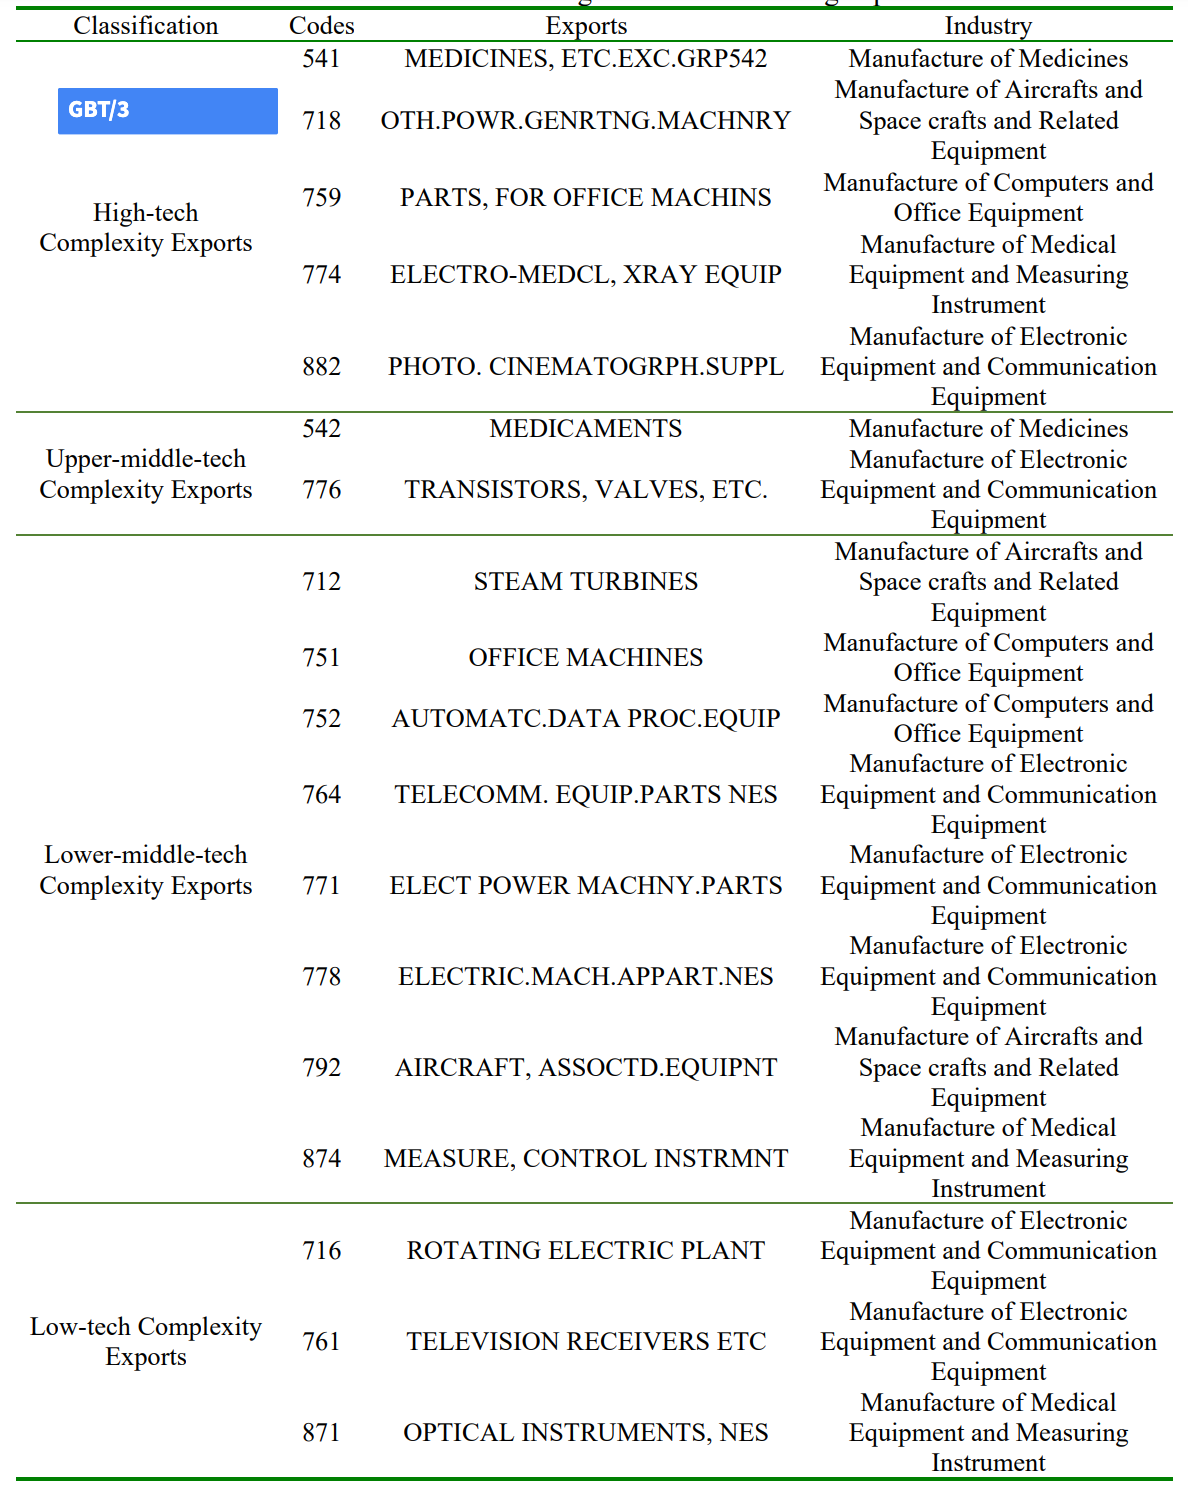

In [ ]:
#!pip install git+https://github.com/thomaspernet/GoogleDrive-python.git

In [ ]:
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_authorization import authorization_service
import os
import numpy as np
import pandas as pd

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

In [ ]:
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")

In [ ]:
auth = authorization_service.get_authorization(
    #path_credential_gcp=os.path.join(parent_path, "creds", "service.json"),
    path_credential_drive=os.path.join(os.getcwd(), "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    os.getcwd(), "creds"))
drive = connect_drive.drive_operations(gd_auth)

In [ ]:
FILENAME_SPREADSHEET = "Product Complexity Rankings 1995 - 2019"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)
df_complexity = (
    drive.download_data_from_spreadsheet(
        sheetID=spreadsheet_id,
        sheetName="Product Complexity Rankings 1995 - 2019.csv",
        to_dataframe=True,
    )
    .rename(columns={"PCI 2002": "PCI_2002"})
    .assign(PCI_2002=lambda x: pd.to_numeric(x["PCI_2002"]))
    .assign(
        hs4=lambda x: np.where(
            x["HS4 Code"].astype("str").str.len() == 3,
            "0" + x["HS4 Code"].astype("str"),
            x["HS4 Code"].astype("str"),
        ),
        rank_2002=lambda x: pd.qcut(
            x["PCI_2002"], 4, labels=["Low-tech Complexity", 
                                      "Lower-middle-tech",
                                      "Upper-middle-tech",
                                     "High-tech"]
        ),
        dummy_tech_1 = lambda x: x['rank_2002'].isin(["Upper-middle-tech",
                                     "High-tech"]), # 50%
        dummy_tech_2 = lambda x: x['rank_2002'].isin(["High-tech"]), #75%
        dummy_tech_3 = lambda x:  x['PCI_2002'] >=0.910580, #80%
        dummy_tech_4 = lambda x:  x['PCI_2002'] >=1.271060, #90%
        dummy_tech_5 = lambda x:  x['PCI_2002'] >=1.535260 #95%
    )
)
df_complexity.to_csv('rank_complexity.csv', index = False)

In [ ]:
df_complexity.head(2)

In [ ]:
df_complexity['PCI_2002'].describe(percentiles= [.75, .80, .90, .95])

In [ ]:
df_complexity.groupby('rank_2002')['PCI_2002'].describe()

In [ ]:
df_complexity.loc[lambda x: x['rank_2002'].isin(['High-tech'])].sort_values(by = ['PCI_2002']).tail()['Product']

In [ ]:
df_final_1 <- df_final %>% 
left_join(read_csv('rank_complexity.csv',
                                           col_types = cols(
                                               hs4 = col_double()
                                           )
                                          )%>%select(Product,
                                           hs4,
                                           rank_2002,
                                           dummy_tech_1,
                                           dummy_tech_2,
                                           dummy_tech_3,
                                                     dummy_tech_4,
                                                     dummy_tech_5
                                                    )) %>%
mutate_at(c('rank_2002'), ~replace(., is.na(.), 'Low-tech Complexity'))%>%
mutate_at(c('dummy_tech_1',
            'dummy_tech_2',
            'dummy_tech_3',
            'dummy_tech_4',
            'dummy_tech_5'
           ), ~replace(., is.na(.), FALSE),
         )


In [ ]:
table(df_final_1$dummy_tech_1)

In [ ]:
table(df_final_1$dummy_tech_2)

In [ ]:
table(df_final_1$dummy_tech_3)

In [ ]:
table(df_final_1$dummy_tech_4)

In [ ]:
table(df_final_1$dummy_tech_5)

### Download RD oriented

In [ ]:
query = """
WITH test AS (
SELECT SUBSTRING(cic, 1, 2) as hs2,
SUM(rdfee) as rdfee,
SUM(total_asset) as total_asset,
CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS rd_total_asset,
CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(output) AS DECIMAL(16, 5)
          ), 
          0
        ) AS rd_output
FROM (
SELECT 
cic, rdfee,output,  CASE WHEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) - (c95 + c97 + c99) > 0 THEN (c95 + c97 + c99) + ABS(
      (
        c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
      ) - (c95 + c97 + c99)
    ) ELSE (c95 + c97 + c99) END AS total_right, 
    CASE WHEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) - (c95 + c97 + c99) < 0 THEN (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) + ABS(
      (
        c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
      ) - (c95 + c97 + c99)
    ) ELSE (
      c80 + c81 + c82 + c79 + tofixed - cudepre + (c91 + c92)
    ) END AS total_asset
    FROM firms_survey.asif_firms_prepared  
WHERE year = '2005'
)
GROUP BY SUBSTRING(cic, 1, 2)
ORDER BY rd_total_asset
) 
SELECT *
FROM test
LEFT JOIN (
    SELECT cic as ind2, short
    FROM chinese_lookup.ind_cic_2_name
    ) as ind_name
    ON test.hs2 = ind_name.ind2
"""
list_rd = s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename='rd',  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        )
list_rd

In [ ]:
(
    list_rd
    .assign(
        #hs4=lambda x: np.where(
        #    x["cic"].astype("str").str.len() == 3,
        #    "0" + x["cic"].astype("str"),
        #   x["cic"].astype("str"),
        #),
        rd_asset = lambda x: x['rd_total_asset'] >=np.quantile(x['rd_total_asset'], 0.75),
        rd_output = lambda x: x['rd_output'] >=np.quantile(x['rd_output'], 0.75)
    )
    .reindex(columns = [
        #'hs4',
        'hs2', 'rd_asset', 'rd_output', 'short'
    ])
    .to_csv('rd_vs_no_rd.csv', index = False)
)

In [ ]:
df_final_rd <-  df_final %>% left_join(
    read_csv('rd_vs_no_rd.csv',
             col_types = cols(
                 hs2 = col_double(),
                 hs4 = col_double()
             ))
) %>%
mutate_at(c('rd_asset','rd_output'), ~replace(., is.na(.), FALSE))

In [ ]:
table(df_final_rd$rd_output)

In [ ]:
table(df_final_rd$rd_asset)

### Dummy

In [ ]:
%get path table
t_1 <- felm(kandhelwal_quality ~rebate* regime* polluted + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted,
            exactDOF = TRUE)
t_1 <- change_target(t_1)

print('table 1 done')
t_2 <- felm(kandhelwal_quality ~rebate* regime * dummy_tech_2 + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1,
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 2 done')

t_3 <- felm(kandhelwal_quality ~rebate* regime * rd_output + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd,
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 4 done')
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_1, t_2, t_3
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'Rare-earth': 2,
    'Polluted intensive': 2,
    'High tech': 2,
    'RD oriented': 2,
    'High skilled oriented': 2
}
reorder = {
    2:0,
    3:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

### subset

In [ ]:
folder = 'Tables_0'
table_nb = 4
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')

In [ ]:
%get path table
#### RARE HEARTH
#t_0 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(hs6 != 850511),
#            exactDOF = TRUE)
#t_0 <- change_target(t_0)
#print('table 0 done')

#t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(hs6 == 850511),
#            exactDOF = TRUE)
#t_1 <- change_target(t_1)
#print('table 0 done')

#### NO LARGE POLLUTED INDUSTRY
t_1 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted %>% filter(polluted == TRUE),
            exactDOF = TRUE)
t_1 <- change_target(t_1)
print('table 1 done')

t_2 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax +
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_polluted %>% filter(polluted == FALSE),
            exactDOF = TRUE)
t_2 <- change_target(t_2)
print('table 1 done')

#### LARGEST COMPLEXITY ->ONE WITH BEST POTENTIAL
t_3 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1 %>% filter(dummy_tech_2 == TRUE),
            exactDOF = TRUE)
t_3 <- change_target(t_3)
print('table 2 done')

t_4 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_1 %>% filter(dummy_tech_2 == FALSE),
            exactDOF = TRUE)
t_4 <- change_target(t_4)
print('table 2 done')
#### SKILLED
#t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(is.na(skilled)),
#            exactDOF = TRUE)
#t_6 <- change_target(t_6)
#print('table 3 done')

#t_7 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
#            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
#            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final %>% filter(!is.na(skilled)),
#            exactDOF = TRUE)
#t_7 <- change_target(t_7)
#print('table 3 done')
##### RD
t_5 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd %>% filter(rd_output == TRUE),
            exactDOF = TRUE)
t_5 <- change_target(t_5)
print('table 3 done')

t_6 <- felm(kandhelwal_quality ~rebate* regime + ln_lag_import_tax * regime+ ln_lag_import_tax+
            lag_foreign_export_share_ckr + lag_soe_export_share_ckr
            | fe_ckr  + fe_kt + fe_jtr|0 | hs6, df_final_rd %>% filter(rd_output == FALSE),
            exactDOF = TRUE)
t_6 <- change_target(t_6)
print('table 3 done')

dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_1, t_2, t_3, t_4, t_5, t_6
),
    title="VAT export tax and firm’s quality upgrading, characteristics of sensible sectors",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    #'Rare-earth': 2,
    'Polluted intensive': 2,
    'High tech': 2,
    'RD oriented': 2,
    #1'High skilled oriented': 2
}
reorder = {
    2:0,
    3:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Yes', 'No', 'Yes', 'No', 'Yes', 'No']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

# Non Tariff Measure

- Model is located here: [checkpoint-2562](https://drive.google.com/drive/folders/13rpnm5X5UG-MgLAFb8r1Pu2F-hvGA443?usp=sharing)

In [ ]:
folder = 'Tables_0'
table_nb = 5
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')

#for ext in ['.txt', '.tex', '.pdf']:
#    x = [a for a in os.listdir(folder) if a.endswith(ext)]
#    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
t_0 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_china),
            exactDOF = TRUE)
   
#### ENV
t_1 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_env),
            exactDOF = TRUE)

### TBT
t_2 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_TBT),
            exactDOF = TRUE)

### SPS
t_3 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_SPS),
            exactDOF = TRUE)
### ADP
t_4 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_ADP),
            exactDOF = TRUE)
### DVP vs L DVP
t_5 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_dvp_c),
            exactDOF = TRUE)

### prevalence
t_6 <- felm(
    kandhelwal_quality ~
    rebate * regime * lag_stock_ntm + 
    rebate * regime * lag_frequency + 
    rebate * regime * lag_prevalence + 
    rebate * regime * lag_coverage + 
    ln_lag_import_tax * regime +
        ln_lag_import_tax  
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6,  df_final %>%select(-lag_stock_ntm) %>% 
    rename(lag_stock_ntm = lag_stock_ntm_china),
            exactDOF = TRUE)
dep <- "Dependent variable: Product quality"
fe1 <- list(
    c("City-product-regime","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Product-year","Yes", "Yes", "Yes", "Yes","Yes","Yes","Yes","Yes"),
    
    c("Destination-year", "Yes", "Yes", "Yes", "Yes","Yes", "Yes","Yes","Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5#, t_6
),
    title="VAT export tax and firm’s quality upgrading NTM anaysis",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = """
This table estimates eq(3). 
Note that 'Eligible' refers to the regime entitle to VAT refund, our treatment group.
Our control group is processing trade with supplied input, 'Non-Eligible' to VAT refund.
Sectors are defined following the Chinese 4-digit GB/T industry
classification and regroup several products.
Heteroskedasticity-robust standard errors
clustered at the product level appear inparentheses.
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."""

multicolumn ={
    'Baseline': 1,
    'Environnement': 1,
    'classification': 3,
    'Developped': 1,
    #'Destination': 1
}
reorder = {
    12:2,
    #5:1
}
multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& ', '', 'TBT', 'SPS', 'ADP', '','','']
lb.beautify(table_number = table_nb,
            #multi_lines_dep = None,
            #reorder_var = reorder,
            multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 180,
            folder = folder)

In [ ]:
summary(
felm(
    kandhelwal_quality ~
    rebate * regime * lag_DV_C +
    ln_lag_import_tax * regime 
            | group_id+fe_ckr +fe_kt + fe_jtr|0, df_final
    %>% group_by(geocode4_corr,year, regime
) %>% mutate(group_id = group_indices())
    ,
            exactDOF = TRUE)
)

In [ ]:
summary(
felm(
    kandhelwal_quality ~
    rebate * regime * DV_C +
    ln_lag_import_tax * regime 
            | group_id+group_id1+fe_ckr +fe_kt + fe_jtr|0, df_final
    %>% group_by(geocode4_corr,year, regime
) %>% mutate(group_id = group_indices())
    ,
            exactDOF = TRUE)
)

In [ ]:
summary(
felm(
    kandhelwal_quality ~
    rebate * regime * lag_DV_C +
    ln_lag_import_tax * regime 
            | fe_ckr  + fe_kt + fe_jtr |0 | hs6, df_final,
            exactDOF = TRUE)
)

In [ ]:
 "DM_C",
            "lag_DM_C",
            "DV_C",
            "lag_DV_C"

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc

In [ ]:
name_json = 'parameters_ETL_VAT_rebate_quality_china.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = True, notebookname = "00_baseline_vat_quality.ipynb")

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)